In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

ImportError: cannot import name 'ConfigProto' from 'tensorflow.keras' (C:\Users\Caleb\Anaconda3\lib\site-packages\tensorflow\keras\__init__.py)

In [6]:
# THIS WILL DOWNLOAD THE IMAGES, not important really

!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip --ssl-no-revoke
!tar -xf kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1  786M    1 14.1M    0     0  17.4M      0  0:00:45 --:--:--  0:00:45 17.4M
  6  786M    6 50.1M    0     0  27.6M      0  0:00:28  0:00:01  0:00:27 27.6M
 11  786M   11 91.6M    0     0  32.6M      0  0:00:24  0:00:02  0:00:22 32.6M
 17  786M   17  135M    0     0  35.6M      0  0:00:22  0:00:03  0:00:19 35.6M
 22  786M   22  179M    0     0  37.2M      0  0:00:21  0:00:04  0:00:17 37.2M
 27  786M   27  214M    0     0  36.8M      0  0:00:21  0:00:05  0:00:16 40.0M
 31  786M   31  248M    0     0  36.5M      0  0:00:21  0:00:06  0:00:15 39.7M
 35  786M   35  282M    0     0  36.1M      0  0:00:21  0:00:07  0:00:14 38.2M
 40  786M   40  316M    0     0  35.9M      0  0:00:21  0:00:08  0:00:13 36.1M
 45  786M   45  360M    0     0  36.7M      0  0:00

In [4]:
!dir

 Volume in drive C is OS
 Volume Serial Number is 5EC9-8460

 Directory of C:\Users\Caleb\Documents\Python Scripts

08/09/2021  09:07 PM    <DIR>          .
08/09/2021  09:07 PM    <DIR>          ..
08/09/2021  08:29 PM    <DIR>          .ipynb_checkpoints
06/07/2021  09:56 AM             2,705 BlobConn.ipynb
01/10/2021  03:32 AM             1,726 fetchTweets.py
06/08/2021  11:42 AM            34,874 flight monitors.ipynb
08/09/2021  08:40 PM       824,894,548 kagglecatsanddogs_3367a.zip
08/09/2021  09:07 PM           575,541 Keras - Image Recognition from Scratch.ipynb
02/10/2017  10:55 AM            35,545 MSR-LA - 3467.docx
08/09/2021  08:38 PM    <DIR>          PetImages
06/04/2021  02:59 PM             3,611 pplmvmnt.ipynb
02/10/2017  10:51 AM               104 readme[1].txt
               8 File(s)    825,548,654 bytes
               4 Dir(s)  565,561,651,200 bytes free


In [20]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images")

Deleted 1578 images


In [21]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


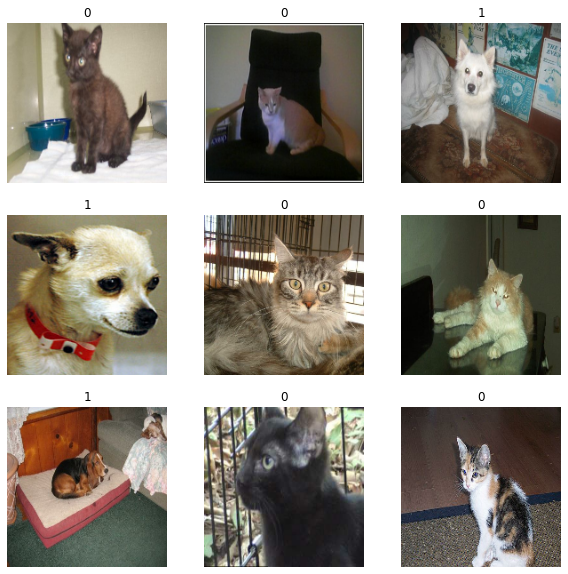

In [36]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

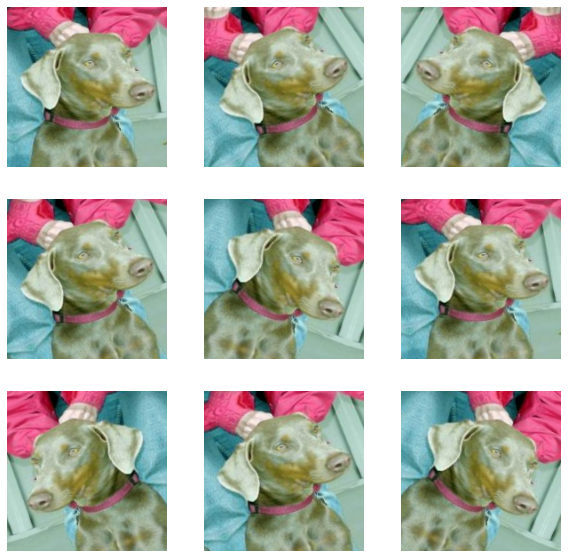

In [14]:
"""
Showing how we can slightly change the images we
already have to make our dataset of images larger
"""

"""
here we are creating a process called "data_augmentation"
data_augmentation is a function that works on a given image
so for every image called 'x' that we put in data_augmentation('x')
it will randomly decide to flip or not flip horizontally
then it will randomly rotate or not rotate the image
so this slightly different image can be passed into 
the image rec model for training
"""

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

#this is the actual code that runs image_augmentation, aund using plt.imshow, we can seee the images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [37]:
# This applies the data_augmentation to all the images in the training set
# it won't run until the program starts
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [38]:
# This code tells the training model to pre-load the images when the training program runs
# that makes it faster since it is loading an image while another is being processed
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [35]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [33]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' or x.device_type == 'CPU']

In [34]:
get_available_devices()

['/device:CPU:0']

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

with tf.device('/device:CPU:0'):
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    model.fit(
        train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
    )

Epoch 1/50
143/586 [======>.......................] - ETA: 39:19 - loss: 0.6992 - accuracy: 0.6075